<a href="https://colab.research.google.com/github/Jimborg7/Examination_Java/blob/master/%CE%A3%CE%9D%CE%94_%CE%B1%CF%83%CE%BA%CE%B7%CF%83%CE%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by taking the data for Covid-19_Radiography_Dataset which includes over 21.000 files and 4 categories 

In [9]:
from google.colab import drive 
drive._mount('/content/drive')

!cp '/content/drive/MyDrive/Covid-19/COVID-19_Radiography_Dataset.zip' .
!unzip -q -n COVID-19_Radiography_Dataset.zip
data_dir = '/content/COVID-19_Radiography_Dataset'
print('Done')

Mounted at /content/drive
Done


Necessary imports such as tensorflow to get the images out of the dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Prepare datasets: get images from main directory. Then split the dataset to devel_ds and test_ds. Devel_ds is the combination of tran_ds and val_ds. Because the images come at categories with labels it is needed to include the label_mode parameter.

In [27]:
def prepare_datasets(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(299, 299)):
    
    #AUTOTUNE = tf.data.AUTOTUNE

    devel_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=train_pct + val_pct,
        # Gia olo to sunolo ginetai iso me to test_pct ara validation_split = test_pct
        color_mode='rgb',
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size)

    # Training set
    train_size = int(round((train_pct + 0.15) * (tf.data.experimental.cardinality(devel_ds).numpy())))
    train_ds = devel_ds.take(train_size)

    # Validate set
    validate_size = int(round((val_pct + 0.05) * (tf.data.experimental.cardinality(devel_ds).numpy())))
    val_tmp = devel_ds.skip(train_size)
    val_ds = val_tmp.take(validate_size)

    # Test set
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=test_pct,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size)

    # List with the names of the 4 classes
    classes = devel_ds.class_names
    print(classes)

    # See the results in a graph to check the number of elements
    '''y = np.concatenate([y for x, y in devel_ds])
    plt.hist(y, list(range(len(classes) + 1)))
    plt.show()'''

   

    return devel_ds, train_ds, val_ds, test_ds, classes

Convolutional network for question 3

In [23]:
def cnn1(num_classes,data_augmented):
    # Normalizing the images from the [0,255] values of RGB to[0,1]
    model = keras.Sequential([
        data_augmented,
        tf.keras.layers.Rescaling(1./255, input_shape=(299, 299, 3)),
        layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Confusion matrix for question 3

In [4]:
def confusion_matrix(model, test_ds):
    y_test = []
    y_pred = []
    for x_1,y_1 in test_ds:
        y_pred_1 = model.predict(x_1)
        y_test.append(y_1)
        y_pred.append(y_pred_1)
    y_true = np.concatenate(y_test)
    y_p = np.concatenate(y_pred)
    y_hat = tf.argmax(y_p,axis = 1)
    cm = tf.math.confusion_matrix(y_true,y_hat)
    return cm, y_hat


Convolutional network for question 4

In [5]:
def cnn2(num_classes,data_augmented):
    model = keras.Sequential([
        data_augmented,
        tf.keras.layers.Rescaling(1. /255, input_shape=(299,299,3)),
        layers.Conv2D(32, kernel_size=(3,3),padding='same',activation='relu'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=4),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Pre designed network to create model for training. Question 5

In [6]:
def pretrained(num_classes ):

    input = layers.Input(shape = (224,224,3))
    x = tf.keras.applications.efficientnet.EfficientNetB0(
            include_top = True,
            weights = None,
            classes = num_classes,
           )(input)
    model = tf.keras.Model(input,x)
    return model

For OverFitting Later

In [7]:
#For Overfitting
def data_augm(img_size):
    data_augmentation = keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ])
    return data_augmentation


Start the modulation 

In [28]:
devel_ds, train_ds, val_ds, test_ds, classes = prepare_datasets(data_dir)
num_classes = len(classes)


Found 21165 files belonging to 4 classes.
Using 4233 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


One hot encoding to train & val and test. 

In [29]:
print(train_ds)

<TakeDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>


Εκπαίδευση Μοντέλου


In [30]:
data_augmentation = data_augm(299)
model = cnn1(num_classes,data_augmentation)

model.summary()
batch_size = 64
epochs = 20

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 299, 299, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 149, 149, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                  

Model.fit - training 

In [31]:
history = model.fit(
    x = train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callback,
    verbose='auto')

Epoch 1/20
50/50 [==============================] - 21s 356ms/step - loss: 1.6013 - accuracy: 0.3872 - val_loss: 1.1530 - val_accuracy: 0.5073
Epoch 2/20
50/50 [==============================] - 18s 345ms/step - loss: 1.1537 - accuracy: 0.4984 - val_loss: 1.1185 - val_accuracy: 0.5005
Epoch 3/20
50/50 [==============================] - 18s 344ms/step - loss: 1.1052 - accuracy: 0.5134 - val_loss: 1.0287 - val_accuracy: 0.5392
Epoch 4/20
50/50 [==============================] - 18s 349ms/step - loss: 1.0420 - accuracy: 0.5450 - val_loss: 0.9897 - val_accuracy: 0.5557
Epoch 5/20
50/50 [==============================] - 18s 345ms/step - loss: 0.9960 - accuracy: 0.5572 - val_loss: 0.9570 - val_accuracy: 0.5857
Epoch 6/20
50/50 [==============================] - 18s 345ms/step - loss: 0.9834 - accuracy: 0.5766 - val_loss: 0.9610 - val_accuracy: 0.5837
Epoch 7/20
50/50 [==============================] - 18s 343ms/step - loss: 0.9536 - accuracy: 0.5997 - val_loss: 0.9367 - val_accuracy: 0.6292

Plot the results to check for overfitting 

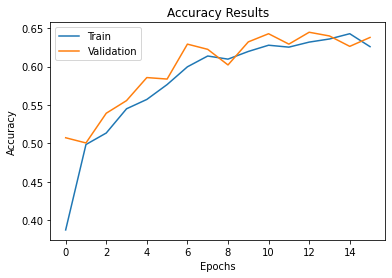

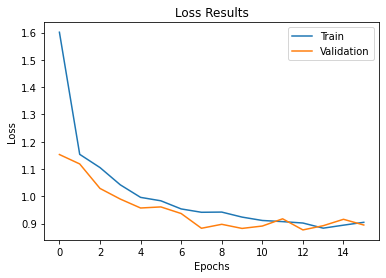

In [32]:

accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title("Accuracy Results")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Validation'])
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss Results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Validation'])
plt.show()


Get confusiont table 


In [33]:
cm , yhat = confusion_matrix(model, test_ds)
print(cm)

tf.Tensor(
[[  24  237  407   10]
 [   4  924  260    8]
 [  61  319 1596   85]
 [  12   87    7  192]], shape=(4, 4), dtype=int32)


In [34]:
print(yhat)

tf.Tensor([2 2 1 ... 2 2 2], shape=(4233,), dtype=int64)


Δεύτερο Μοντέλο με περισσότερα επίπεδα και φίλτρα


In [35]:
model2 = cnn2(num_classes, data_augmentation)
model2.summary()
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])

history2 =model2.fit(
    x = train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callback,
    verbose='auto')



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 299, 299, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 64)        18496     
                                                     

Plot the results 

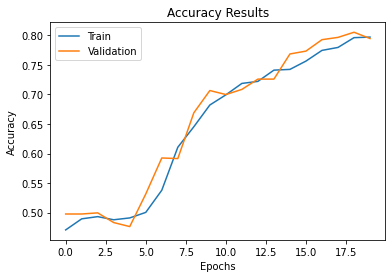

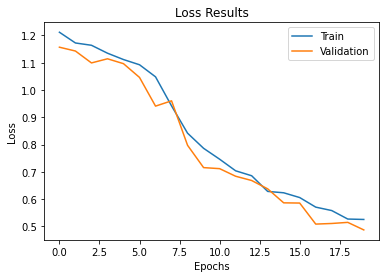

In [36]:
accuracy = history2.history['accuracy']
loss = history2.history['loss']

val_accuracy = history2.history['val_accuracy']
val_loss = history2.history['val_loss']


plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title("Accuracy Results")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Validation'])
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss Results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Validation'])
plt.show()

Confusion Table for model 2

In [37]:
cm2, y_hat2 = confusion_matrix(model2, test_ds)
print(cm2)

tf.Tensor(
[[ 440   78  154    6]
 [  92  881  216    7]
 [  93  102 1863    3]
 [   2    6   37  253]], shape=(4, 4), dtype=int32)


Model 3 with pre trained network

In [38]:
model3 = pretrained(num_classes)
model3.summary()

##Re-sizing the train, val, and test dss
epochs = 5
batch_size = 32
size = (224, 224)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])
history3 = model3.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callback,
    verbose='auto')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4)                4054695   
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/5
50/50 [==============================] - 88s 2s/step - loss: 2.3571 - accuracy: 0.4600 - val_loss: 1.2154 - val_accuracy: 0.2807
Epoch 2/5
50/50 [==============================] - 65s 1s/step - loss: 1.6484 - accuracy: 0.5884 - val_loss: 1.2083 - val_accuracy: 0.4811
Epoch 3/5
50/50 [==============================] - 65s 1s/step - loss: 1.1235 - accuracy: 0.6756 - val_loss: 1.3743 - val_accuracy: 0.1675
Epoch 4/5
50/50 [========

Plot results fro third model 

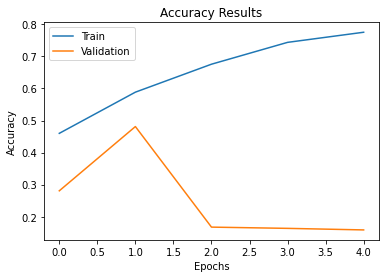

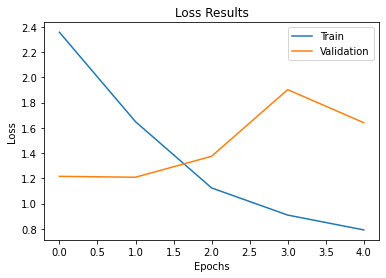

In [39]:
accuracy = history3.history['accuracy']
loss = history3.history['loss']

val_accuracy = history3.history['val_accuracy']
val_loss = history3.history['val_loss']


plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title("Accuracy Results")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Validation'])
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss Results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Validation'])
plt.show()

Confusion table model 3

In [40]:
cm3, y_hat3 = confusion_matrix(model3, test_ds)
print(cm3, y_hat3)


tf.Tensor(
[[ 678    0    0    0]
 [1196    0    0    0]
 [2061    0    0    0]
 [ 298    0    0    0]], shape=(4, 4), dtype=int32) tf.Tensor([0 0 0 ... 0 0 0], shape=(4233,), dtype=int64)
